In [6]:
import pandas as pd
import scipy.stats as stats
import pandas as pd
from sklearn.linear_model import LogisticRegression
from pymatch.Matcher import Matcher
from sklearn.linear_model import LogisticRegression
from pymatch.Matcher import Matcher

In [7]:
data_bank=pd.read_csv("DiD_data.csv")

In [8]:
data_bank.head()

rssd9001  rssd9999  bhc_avgtradingratio  treat_3_b_avg  after_DFA_1  \
0   1020180  20040930                  0.0              0            0   
1   1020180  20041231                  0.0              0            0   
2   1020180  20050331                  0.0              0            0   
3   1020180  20050630                  0.0              0            0   
4   1020180  20050930                  0.0              0            0   

   dep_roa1  dep_leverage  dep_lnassets  dep_creditrisk_total3   dep_cir  \
0  0.002772      0.081957     15.601202               0.013304  0.463811   
1  0.003045      0.082480     15.630583               0.009732  0.456392   
2  0.002616      0.082074     15.644925               0.011830  0.444011   
3  0.002647      0.081712     15.679702               0.013654  0.433771   
4  0.002867      0.082944     15.661868               0.012456  0.400985   

   dep_depositratio  dep_loans_REratio  dep_liquidity  dep_cpp_bankquarter  
0          0.561805           0.593738       0.024337                    0  
1          0.557617           0.601763       0.025446                    0  
2          0.556980           0.600700       0.025153                    0  
3          0.571642           0.601042       0.023670                    0  
4          0.577408           0.581438       0.029793                    0

In [9]:
data_bank=data_bank.dropna()
data_bank.shape

(40026, 14)

In [10]:
data_bank['rssd9001'].nunique()

2428

## statistical test 

In [11]:
data_cor=data_bank[data_bank['after_DFA_1']==0]

data_cor=data_cor.loc[:,["bhc_avgtradingratio","dep_roa1","dep_leverage","dep_lnassets","dep_creditrisk_total3","dep_cir","dep_depositratio","dep_loans_REratio","dep_liquidity"]]

#Calculate the correlation matrix for all four columns
correlations = data_cor.corr()['bhc_avgtradingratio'] 

print("Correlations with 'Output' column:")
print(correlations)

Correlations with 'Output' column:
bhc_avgtradingratio      1.000000
dep_roa1                -0.014601
dep_leverage            -0.045061
dep_lnassets             0.404403
dep_creditrisk_total3    0.015372
dep_cir                 -0.005097
dep_depositratio        -0.365469
dep_loans_REratio       -0.183954
dep_liquidity            0.071550
Name: bhc_avgtradingratio, dtype: float64


In [12]:
data_an=data_bank[data_bank['after_DFA_1']==0]
data_an=data_an.dropna(subset=['bhc_avgtradingratio'])
grouped_data = [data_an['bhc_avgtradingratio'][data_an['dep_cpp_bankquarter'] == category] for category in data_an['dep_cpp_bankquarter'].unique()]
f_statistic, p_value = stats.f_oneway(*grouped_data)

# Print the results
print("F-statistic:", f_statistic)
print("p-value:", p_value)

F-statistic: 25.513516767952233
p-value: 4.4245643999030296e-07


##### From the above two test we are able to get dep_lnassets and  dep_depositratio moderatly correlated and for dep_cpp_bankquarter it is significant 

### implementing affect 

In [13]:
data_alert=data_bank[["rssd9001","rssd9999","bhc_avgtradingratio"]]

In [14]:
data_alert

rssd9001  rssd9999  bhc_avgtradingratio
0       1020180  20040930                  0.0
1       1020180  20041231                  0.0
2       1020180  20050331                  0.0
3       1020180  20050630                  0.0
4       1020180  20050930                  0.0
...         ...       ...                  ...
40021   3832583  20140331                  0.0
40022   3832583  20140630                  0.0
40023   3832583  20140930                  0.0
40024   3832583  20141231                  0.0
40025   3836442  20090630                  0.0

[40026 rows x 3 columns]

In [15]:
data_alert['rssd9001'].nunique()

2428

In [16]:
data_alert['rssd9999'] = [str(date) for date in data_alert['rssd9999'] ]
data_alert['rssd9999']=[pd.to_datetime(i, format='%Y%m%d') for i in data_alert['rssd9999']]
#date_datetime = pd.to_datetime(date_strings, format='%Y%m%d')

C:\Users\AKHIL ANNA\AppData\Local\Temp\ipykernel_10428\378091898.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_alert['rssd9999'] = [str(date) for date in data_alert['rssd9999'] ]
C:\Users\AKHIL ANNA\AppData\Local\Temp\ipykernel_10428\378091898.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_alert['rssd9999']=[pd.to_datetime(i, format='%Y%m%d') for i in data_alert['rssd9999']]


In [17]:
data_alert['rssd9999'] = pd.to_datetime(data_alert['rssd9999'])

# Filter data for the year range 2004 to 2009
start_date = pd.to_datetime('2004-01-01')
end_date = pd.to_datetime('2009-12-31')
filtered_df = data_alert[(data_alert['rssd9999'] >= start_date) & (data_alert['rssd9999'] <= end_date)]

# Group by 'CompanyID' and calculate the average 'TradingRatio'
average_trading_ratio = filtered_df.groupby('rssd9001')['bhc_avgtradingratio'].mean().reset_index()

average_trading_ratio
average_trading_ratio = average_trading_ratio.rename(columns={'bhc_avgtradingratio': 'Affect'})
merge_bank = pd.merge(data_bank, average_trading_ratio, on='rssd9001', how='left')
merge_bank

C:\Users\AKHIL ANNA\AppData\Local\Temp\ipykernel_10428\3199606959.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_alert['rssd9999'] = pd.to_datetime(data_alert['rssd9999'])


rssd9001  rssd9999  bhc_avgtradingratio  treat_3_b_avg  after_DFA_1  \
0       1020180  20040930                  0.0              0            0   
1       1020180  20041231                  0.0              0            0   
2       1020180  20050331                  0.0              0            0   
3       1020180  20050630                  0.0              0            0   
4       1020180  20050930                  0.0              0            0   
...         ...       ...                  ...            ...          ...   
40021   3832583  20140331                  0.0              0            1   
40022   3832583  20140630                  0.0              0            1   
40023   3832583  20140930                  0.0              0            1   
40024   3832583  20141231                  0.0              0            1   
40025   3836442  20090630                  0.0              0            0   

       dep_roa1  dep_leverage  dep_lnassets  dep_creditrisk_total3   dep_cir  \
0      0.002772      0.081957     15.601202               0.013304  0.463811   
1      0.003045      0.082480     15.630583               0.009732  0.456392   
2      0.002616      0.082074     15.644925               0.011830  0.444011   
3      0.002647      0.081712     15.679702               0.013654  0.433771   
4      0.002867      0.082944     15.661868               0.012456  0.400985   
...         ...           ...           ...                    ...       ...   
40021  0.006362      0.225532     13.525286               0.008318  0.528542   
40022  0.006616      0.224154     13.519756               0.007821  0.490698   
40023  0.006579      0.226952     13.523643               0.008012  0.469434   
40024  0.006423      0.227009     13.552240               0.008406  0.473358   
40025 -0.006128      0.050489     13.462799               0.070051  0.373026   

       dep_depositratio  dep_loans_REratio  dep_liquidity  \
0              0.561805           0.593738       0.024337   
1              0.557617           0.601763       0.025446   
2              0.556980           0.600700       0.025153   
3              0.571642           0.601042       0.023670   
4              0.577408           0.581438       0.029793   
...                 ...                ...            ...   
40021          0.720636           0.001986       0.081983   
40022          0.724049           0.002048       0.084540   
40023          0.716915           0.001870       0.075759   
40024          0.709474           0.001760       0.074139   
40025          0.615129           0.959304       0.016958   

       dep_cpp_bankquarter  Affect  
0                        0     0.0  
1                        0     0.0  
2                        0     0.0  
3                        0     0.0  
4                        0     0.0  
...                    ...     ...  
40021                    0     0.0  
40022                    0     0.0  
40023                    0     0.0  
40024                    0     0.0  
40025                    0     0.0  

[40026 rows x 15 columns]

## DID

In [18]:
data_test=merge_bank
data_test['Affect*after_DFA_1']=data_test['after_DFA_1']*data_test['Affect']

In [20]:
import statsmodels.api as sm

cat_dummy=pd.get_dummies(data_test['dep_cpp_bankquarter'], prefix='bank', drop_first=True)
cat_dummy= cat_dummy.astype(int)
data_test_fixed_effect_5=pd.DataFrame()
data_test_fixed_effect_5=pd.concat([data_test,cat_dummy], axis=1)
X = sm.add_constant(data_test_fixed_effect_5[['Affect','after_DFA_1','dep_lnassets','Affect*after_DFA_1','dep_depositratio']+list(cat_dummy.columns)])
#X = sm.add_constant(data_test_fixed_effect_5[['after_DFA_1*treat_3_b_avg','dep_lnassets','dep_depositratio','dep_loans_REratio']+list(cat_dummy.columns)])
y = data_test['bhc_avgtradingratio']


model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     bhc_avgtradingratio   R-squared:                       0.902
Model:                             OLS   Adj. R-squared:                  0.902
Method:                  Least Squares   F-statistic:                 6.120e+04
Date:                 Thu, 19 Oct 2023   Prob (F-statistic):               0.00
Time:                         21:16:12   Log-Likelihood:             1.4705e+05
No. Observations:                40026   AIC:                        -2.941e+05
Df Residuals:                    40019   BIC:                        -2.940e+05
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0033      0.000     -7.128      0.000      -0.004      -0.002
Affect                 0.9928      0.002    405.033      0.000       0.988       0.998
after_DFA_1         1.992e-05    6.7e-05      0.297      0.766      -0.000       0.000
dep_lnassets           0.0002   2.66e-05      8.760      0.000       0.000       0.000
Affect*after_DFA_1    -0.1604      0.003    -52.682      0.000      -0.166      -0.154
dep_depositratio       0.0002      0.000      0.808      0.419      -0.000       0.001
bank_1                -0.0002      0.000     -1.773      0.076      -0.000    2.34e-05
==============================================================================
Omnibus:                    51872.408   Durbin-Watson:                   0.524
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        103636241.029
Skew:                           6.360   Prob(JB):                         0.00
Kurtosis:                     251.957   Cond. No.                     1.66e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.66e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## DiD with fixed effect 

In [21]:
bank_dummies = pd.get_dummies(data_test['rssd9001'], prefix='bank', drop_first=True)
bank_dummies= bank_dummies.astype(int)
time_dummies=  pd.get_dummies(data_test['rssd9999'], prefix='bank', drop_first=True)
time_dummies= time_dummies.astype(int)
cat_dummy=pd.get_dummies(data_test['dep_cpp_bankquarter'], prefix='bank', drop_first=True)
cat_dummy= cat_dummy.astype(int)
data_test_fixed_effect_4 = pd.DataFrame()
data_test_fixed_effect_4 = pd.concat([data_test, bank_dummies,time_dummies,cat_dummy], axis=1)
covariates =['dep_lnassets', 'dep_depositratio']

X = sm.add_constant(data_test_fixed_effect_4[['Affect*after_DFA_1']+list(bank_dummies.columns)+list(time_dummies.columns)+list(cat_dummy.columns)+covariates])
y = data_test['bhc_avgtradingratio']

model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     bhc_avgtradingratio   R-squared:                       0.925
Model:                             OLS   Adj. R-squared:                  0.920
Method:                  Least Squares   F-statistic:                     187.0
Date:                 Thu, 19 Oct 2023   Prob (F-statistic):               0.00
Time:                         21:17:03   Log-Likelihood:             1.5239e+05
No. Observations:                40026   AIC:                        -2.998e+05
Df Residuals:                    37557   BIC:                        -2.786e+05
Df Model:                         2468                                         
Covariance Type:             nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0014      0.003      0.525      0.600      -0.004       0.007
Affect*after_DFA_1    -0.1980      0.004    -55.611      0.000      -0.205      -0.191
bank_1020201           0.1353      0.002     54.187      0.000       0.130       0.140
bank_1020340           0.0178      0.002     11.030      0.000       0.015       0.021
bank_1020395        9.341e-05      0.002      0.037      0.970      -0.005       0.005
bank_1020582           0.0001      0.002      0.046      0.964      -0.005       0.005
bank_1020676          -0.0003      0.001     -0.237      0.812      -0.003       0.002
bank_1020902           0.0178      0.001     13.878      0.000       0.015       0.020
bank_1020920        5.027e-05      0.003      0.020      0.984      -0.005       0.005
bank_1021570        -4.87e-06      0.003     -0.002      0.998      -0.005       0.005
bank_1021682          -0.0004      0.001     -0.287      0.774      -0.003       0.002
bank_1021879           0.0001      0.002      0.061      0.952      -0.004       0.005
bank_1022166        5.348e-05      0.003      0.021      0.983      -0.005       0.005
bank_1022269           0.0002      0.003      0.061      0.951      -0.005       0.005
bank_1022764           0.0001      0.001      0.086      0.931      -0.002       0.003
bank_1022997           0.0002      0.002      0.070      0.944      -0.005       0.005
bank_1023154          -0.0005      0.001     -0.337      0.736      -0.003       0.002
bank_1023239          -0.0002      0.001     -0.187      0.852      -0.003       0.002
bank_1025309           0.0047      0.001      3.646      0.000       0.002       0.007
bank_1025541        -1.67e-05      0.001     -0.013      0.990      -0.003       0.002
bank_1025608           0.0035      0.001      2.656      0.008       0.001       0.006
bank_1025662          -0.0004      0.001     -0.310      0.757      -0.003       0.002
bank_1026632           0.0088      0.002      4.855      0.000       0.005       0.012
bank_1026801           0.0002      0.001      0.183      0.855      -0.002       0.003
bank_1027004           0.0055      0.001      4.162      0.000       0.003       0.008
bank_1027518           0.0040      0.001      3.132      0.002       0.002       0.007
bank_1027947       -2.364e-06      0.003     -0.001      0.999      -0.005       0.005
bank_1027992        9.347e-05      0.003      0.031      0.975      -0.006       0.006
bank_1028038           0.0002      0.002      0.094      0.925      -0.004       0.005
bank_1028533          -0.0004      0.001     -0.330      0.741      -0.003       0.002
bank_1029222        5.807e-05      0.001      0.045      0.964      -0.002       0.003
bank_1029295        9.198e-05      0.003      0.037      0.971      -0.005       0.005
bank_1029334          -0.00

## DID with Affected BHC

In [34]:
data_test['treat_3_b_avg*after_DFA_1']=data_test['treat_3_b_avg']*data_test['after_DFA_1']
bank_dummies = pd.get_dummies(data_test['rssd9001'], prefix='bank', drop_first=True)
bank_dummies= bank_dummies.astype(int)
time_dummies=  pd.get_dummies(data_test['rssd9999'], prefix='bank', drop_first=True)
time_dummies= time_dummies.astype(int)
cat_dummy=pd.get_dummies(data_test['dep_cpp_bankquarter'], prefix='bank', drop_first=True)
cat_dummy= cat_dummy.astype(int)
data_test_fixed_effect_6 = pd.DataFrame()
data_test_fixed_effect_6 = pd.concat([data_test, bank_dummies,time_dummies,cat_dummy], axis=1)
covariates =['dep_lnassets', 'dep_depositratio']

X = sm.add_constant(data_test_fixed_effect_6[['treat_3_b_avg*after_DFA_1']+list(bank_dummies.columns)+list(time_dummies.columns)+list(cat_dummy.columns)+covariates])
y = data_test['bhc_avgtradingratio']

model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     bhc_avgtradingratio   R-squared:                       0.922
Model:                             OLS   Adj. R-squared:                  0.917
Method:                  Least Squares   F-statistic:                     181.1
Date:                 Thu, 19 Oct 2023   Prob (F-statistic):               0.00
Time:                         22:46:33   Log-Likelihood:             1.5179e+05
No. Observations:                40026   AIC:                        -2.986e+05
Df Residuals:                    37557   BIC:                        -2.774e+05
Df Model:                         2468                                         
Covariance Type:             nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.0012      0.003      0.442      0.659      -0.004       0.007
treat_3_b_avg*after_DFA_1    -0.0229      0.001    -43.477      0.000      -0.024      -0.022
bank_1020201                  0.1353      0.003     53.362      0.000       0.130       0.140
bank_1020340                  0.0169      0.002     10.294      0.000       0.014       0.020
bank_1020395               6.262e-05      0.003      0.025      0.980      -0.005       0.005
bank_1020582               8.925e-05      0.003      0.035      0.972      -0.005       0.005
bank_1020676                 -0.0003      0.001     -0.203      0.839      -0.003       0.002
bank_1020902                  0.0151      0.001     11.596      0.000       0.013       0.018
bank_1020920                2.01e-05      0.003      0.008      0.994      -0.005       0.005
bank_1021570              -5.677e-05      0.003     -0.022      0.982      -0.005       0.005
bank_1021682                 -0.0004      0.001     -0.260      0.795      -0.003       0.002
bank_1021879                  0.0002      0.002      0.067      0.947      -0.004       0.005
bank_1022166               2.983e-05      0.003      0.012      0.991      -0.005       0.005
bank_1022269                  0.0002      0.003      0.072      0.942      -0.005       0.005
bank_1022764                  0.0001      0.001      0.105      0.917      -0.002       0.003
bank_1022997                  0.0001      0.003      0.057      0.954      -0.005       0.005
bank_1023154                 -0.0005      0.001     -0.342      0.732      -0.003       0.002
bank_1023239                 -0.0002      0.001     -0.178      0.859      -0.003       0.002
bank_1025309                  0.0042      0.001      3.210      0.001       0.002       0.007
bank_1025541                  0.0001      0.001      0.087      0.930      -0.002       0.003
bank_1025608                  0.0034      0.001      2.495      0.013       0.001       0.006
bank_1025662                 -0.0004      0.001     -0.297      0.767      -0.003       0.002
bank_1026632                  0.0088      0.002      4.773      0.000       0.005       0.012
bank_1026801                  0.0003      0.001      0.242      0.809      -0.002       0.003
bank_1027004                  0.0050      0.001      3.720      0.000       0.002       0.008
bank_1027518                  0.0036      0.001      2.755      0.006       0.001       0.006
bank_1027947              -5.329e-05      0.003     -0.021      0.983      -0.005       0.005
bank_1027992               8.794e-05      0.003      0.029      0.977      -0.006       0.006
bank_1028038                  0.0002      0.002      0.076      0.940      -0.004       0.005
bank_1028533                 -0.0004      0.001     -0.326      

## propensity_scores

In [23]:
data_test['rssd9999']=data_test['rssd9999'].astype(str)
data_test['month']=data_test['rssd9999'].str[4:6]
data_qr=data_test[data_test['month']=='03']

In [24]:
covariates = data_qr[['dep_lnassets', 'dep_depositratio', 'dep_cpp_bankquarter']]  # Adjust column names
treatment = data_qr['treat_3_b_avg']  

In [25]:
logistic_model = LogisticRegression(solver='lbfgs')
logistic_model.fit(covariates, treatment)
propensity_scores = logistic_model.predict_proba(covariates)[:, 1]

data_qr['propensity_score'] = propensity_scores


C:\Users\AKHIL ANNA\AppData\Local\Temp\ipykernel_10428\2006353029.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_qr['propensity_score'] = propensity_scores


## Matching groups

In [26]:
treated_group = data_qr[data_qr['treat_3_b_avg'] == 1]
control_group = data_qr[data_qr['treat_3_b_avg'] == 0]
k = 3  # You can adjust this to select more or fewer matches

matched_indices = []

for index, row in treated_group.iterrows():
    differences = abs(control_group['propensity_score'] - row['propensity_score'])
    
    # Use argsort to get the indices of the top-k closest neighbors
    nearest_neighbor_indices = differences.argsort()[:k]

    # Ensure that the indices exist in the control_group DataFrame
    valid_indices = [index for index in nearest_neighbor_indices if index in control_group.index]

    # Append the valid indices to the matched_indices list
    matched_indices.extend(valid_indices)

# Use the matched indices to create the matched_control_group DataFrame
matched_control_group = control_group.loc[matched_indices]
#print(matched_control_group.shape)
propensity_score_matched = matched_control_group.drop_duplicates()
#print(propensity_score_matched.shape)
propensity_score_matched=pd.concat([treated_group,propensity_score_matched])
propensity_score_matched_1=propensity_score_matched[['rssd9001']]
did_propensity = pd.merge(data_test,propensity_score_matched_1 , on='rssd9001', how='inner')

## DID with propensity_scores

In [27]:
did_propensity

rssd9001  rssd9999  bhc_avgtradingratio  treat_3_b_avg  after_DFA_1  \
0      1020201  20040930             0.126453              1            0   
1      1020201  20041231             0.139026              1            0   
2      1020201  20050331             0.130043              1            0   
3      1020201  20050630             0.131771              1            0   
4      1020201  20050930             0.135333              1            0   
...        ...       ...                  ...            ...          ...   
5582   3587146  20141231             0.052628              1            1   
5583   3587146  20141231             0.052628              1            1   
5584   3587146  20141231             0.052628              1            1   
5585   3587146  20141231             0.052628              1            1   
5586   3587146  20141231             0.052628              1            1   

      dep_roa1  dep_leverage  dep_lnassets  dep_creditrisk_total3   dep_cir  \
0     0.002906      0.070028     18.610798               0.013813  0.339097   
1     0.002053      0.074122     18.764626               0.014689  0.414206   
2     0.002237      0.076953     18.768549               0.015002  0.357776   
3     0.001485      0.078767     18.788057               0.015216  0.372252   
4     0.001715      0.080054     18.818710               0.016574  0.325251   
...        ...           ...           ...                    ...       ...   
5582  0.000604      0.098357     19.769541               0.005375  0.938482   
5583  0.000604      0.098357     19.769541               0.005375  0.938482   
5584  0.000604      0.098357     19.769541               0.005375  0.938482   
5585  0.000604      0.098357     19.769541               0.005375  0.938482   
5586  0.000604      0.098357     19.769541               0.005375  0.938482   

      dep_depositratio  dep_loans_REratio  dep_liquidity  dep_cpp_bankquarter  \
0             0.390303           0.758043       0.044461                    0   
1             0.358281           0.647956       0.042322                    0   
2             0.357660           0.651144       0.045373                    0   
3             0.362995           0.642943       0.046566                    0   
4             0.376771           0.623793       0.042985                    0   
...                ...                ...            ...                  ...   
5582          0.133847           0.131263       0.327403                    0   
5583          0.133847           0.131263       0.327403                    0   
5584          0.133847           0.131263       0.327403                    0   
5585          0.133847           0.131263       0.327403                    0   
5586          0.133847           0.131263       0.327403                    0   

        Affect  Affect*after_DFA_1  treat_3_b_avg*after_DFA_1 month  
0     0.134151            0.000000                          0    09  
1     0.134151            0.000000                          0    12  
2     0.134151            0.000000                          0    03  
3     0.134151            0.000000                          0    06  
4     0.134151            0.000000                          0    09  
...        ...                 ...                        ...   ...  
5582  0.042943            0.042943                          1    12  
5583  0.042943            0.042943                          1    12  
5584  0.042943            0.042943                          1    12  
5585  0.042943            0.042943                          1    12  
5586  0.042943            0.042943                          1    12  

[5587 rows x 18 columns]

In [28]:
bank_dummies = pd.get_dummies(did_propensity['rssd9001'], prefix='bank', drop_first=True)
bank_dummies= bank_dummies.astype(int)
time_dummies=  pd.get_dummies(did_propensity['rssd9999'], prefix='bank', drop_first=True)
time_dummies= time_dummies.astype(int)
cat_dummy=pd.get_dummies(did_propensity['dep_cpp_bankquarter'], prefix='bank', drop_first=True)
cat_dummy= cat_dummy.astype(int)
data_test_fixed_effect_7 = pd.DataFrame()
data_test_fixed_effect_7 = pd.concat([did_propensity, bank_dummies,time_dummies,cat_dummy], axis=1)
covariates =['dep_lnassets', 'dep_depositratio']

X = sm.add_constant(data_test_fixed_effect_7[['treat_3_b_avg*after_DFA_1']+list(bank_dummies.columns)+list(time_dummies.columns)+list(cat_dummy.columns)+covariates])
y = did_propensity['bhc_avgtradingratio']

model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     bhc_avgtradingratio   R-squared:                       0.927
Model:                             OLS   Adj. R-squared:                  0.926
Method:                  Least Squares   F-statistic:                     636.6
Date:                 Thu, 19 Oct 2023   Prob (F-statistic):               0.00
Time:                         21:18:18   Log-Likelihood:                 12836.
No. Observations:                 5587   AIC:                        -2.545e+04
Df Residuals:                     5476   BIC:                        -2.471e+04
Df Model:                          110                                         
Covariance Type:             nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.3857      0.032     12.157      0.000       0.323       0.448
treat_3_b_avg*after_DFA_1    -0.0193      0.002    -12.097      0.000      -0.022      -0.016
bank_1020676                 -0.2303      0.014    -16.703      0.000      -0.257      -0.203
bank_1020902                 -0.1844      0.012    -15.500      0.000      -0.208      -0.161
bank_1023154                 -0.2466      0.015    -16.819      0.000      -0.275      -0.218
bank_1023239                 -0.2283      0.014    -16.754      0.000      -0.255      -0.202
bank_1029464                 -0.2115      0.013    -16.579      0.000      -0.236      -0.186
bank_1029884                 -0.1897      0.012    -15.355      0.000      -0.214      -0.165
bank_1030947                 -0.2367      0.014    -16.792      0.000      -0.264      -0.209
bank_1031449                 -0.1747      0.012    -14.955      0.000      -0.198      -0.152
bank_1031627                 -0.2268      0.014    -16.321      0.000      -0.254      -0.200
bank_1032473                 -0.0646      0.011     -5.946      0.000      -0.086      -0.043
bank_1033470                 -0.0802      0.011     -7.346      0.000      -0.102      -0.059
bank_1039502                  0.1431      0.011     13.125      0.000       0.122       0.164
bank_1042351                  0.0076      0.016      0.465      0.642      -0.024       0.039
bank_1048812                 -0.2268      0.013    -16.889      0.000      -0.253      -0.200
bank_1050909                 -0.2381      0.014    -16.927      0.000      -0.266      -0.211
bank_1051979                 -0.2464      0.015    -16.851      0.000      -0.275      -0.218
bank_1052378                 -0.2362      0.015    -16.246      0.000      -0.265      -0.208
bank_1053272                 -0.2162      0.013    -17.100      0.000      -0.241      -0.191
bank_1054514                 -0.2306      0.013    -17.163      0.000      -0.257      -0.204
bank_1055007                 -0.2321      0.014    -16.656      0.000      -0.259      -0.205
bank_1056657                 -0.2448      0.018    -13.667      0.000      -0.280      -0.210
bank_1056684                 -0.2429      0.018    -13.782      0.000      -0.277      -0.208
bank_1056769                 -0.2452      0.016    -15.787      0.000      -0.276      -0.215
bank_1064429                 -0.2389      0.014    -16.814      0.000      -0.267      -0.211
bank_1068191                 -0.1632      0.011    -14.626      0.000      -0.185      -0.141
bank_1068762                 -0.1251      0.012    -10.018      0.000      -0.150      -0.101
bank_1070756                 -0.2446      0.015    -16.831      0.000      -0.273      -0.216
bank_1071463                 -0.2372      0.017    -13.738      

## selecting from 2004 to 2007 As Affect

In [29]:
data_alert['rssd9999'] = pd.to_datetime(data_alert['rssd9999'])

# Filter data for the year range 2004 to 2009
start_date = pd.to_datetime('2004-01-01')
end_date = pd.to_datetime('2007-12-31')
filtered_df = data_alert[(data_alert['rssd9999'] >= start_date) & (data_alert['rssd9999'] <= end_date)]

# Group by 'CompanyID' and calculate the average 'TradingRatio'
average_trading_ratio_2 = filtered_df.groupby('rssd9001')['bhc_avgtradingratio'].mean().reset_index()

average_trading_ratio_2

C:\Users\AKHIL ANNA\AppData\Local\Temp\ipykernel_10428\2607443909.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_alert['rssd9999'] = pd.to_datetime(data_alert['rssd9999'])


rssd9001  bhc_avgtradingratio
0      1020180             0.000000
1      1020201             0.134151
2      1020340             0.010729
3      1020395             0.000000
4      1020582             0.000000
...        ...                  ...
2373   3587146             0.039638
2374   3589560             0.000000
2375   3590388             0.000000
2376   3595422             0.000000
2377   3602067             0.019892

[2378 rows x 2 columns]

In [30]:
average_trading_ratio_2 = average_trading_ratio_2.rename(columns={'bhc_avgtradingratio': 'Affect'})
merge_bank_2007 = pd.merge(data_bank, average_trading_ratio_2, on='rssd9001', how='left')
merge_bank_2007
merge_bank_2007=merge_bank_2007.dropna()

In [31]:
bank_dummies = pd.get_dummies(merge_bank_2007['rssd9001'], prefix='bank', drop_first=True)
bank_dummies= bank_dummies.astype(int)
time_dummies=  pd.get_dummies(merge_bank_2007['rssd9999'], prefix='bank', drop_first=True)
time_dummies= time_dummies.astype(int)
cat_dummy=pd.get_dummies(merge_bank_2007['dep_cpp_bankquarter'], prefix='bank', drop_first=True)
cat_dummy= cat_dummy.astype(int)
merge_bank_2007['Affect*after_DFA_1']=merge_bank_2007['after_DFA_1']*merge_bank_2007['Affect']
data_test_fixed_effect_8 = pd.DataFrame()
data_test_fixed_effect_8 = pd.concat([merge_bank_2007, bank_dummies,time_dummies,cat_dummy], axis=1)
covariates =['dep_lnassets', 'dep_depositratio']

X = sm.add_constant(data_test_fixed_effect_8[['Affect*after_DFA_1']+list(bank_dummies.columns)+list(time_dummies.columns)+list(cat_dummy.columns)+covariates])
y = merge_bank_2007['bhc_avgtradingratio']

model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     bhc_avgtradingratio   R-squared:                       0.896
Model:                             OLS   Adj. R-squared:                  0.889
Method:                  Least Squares   F-statistic:                     130.9
Date:                 Thu, 19 Oct 2023   Prob (F-statistic):               0.00
Time:                         21:19:10   Log-Likelihood:             1.4922e+05
No. Observations:                39189   AIC:                        -2.936e+05
Df Residuals:                    36770   BIC:                        -2.729e+05
Df Model:                         2418                                         
Covariance Type:             nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0017      0.003      0.619      0.536      -0.004       0.007
Affect*after_DFA_1    -0.2127      0.004    -54.897      0.000      -0.220      -0.205
bank_1020201           0.1354      0.002     54.226      0.000       0.131       0.140
bank_1020340           0.0176      0.002     10.895      0.000       0.014       0.021
bank_1020395        1.353e-06      0.002      0.001      1.000      -0.005       0.005
bank_1020582         2.88e-05      0.002      0.012      0.991      -0.005       0.005
bank_1020676          -0.0004      0.001     -0.268      0.789      -0.003       0.002
bank_1020902           0.0180      0.001     14.060      0.000       0.015       0.021
bank_1020920        -4.98e-05      0.003     -0.020      0.984      -0.005       0.005
bank_1021570          -0.0001      0.003     -0.050      0.960      -0.005       0.005
bank_1021682          -0.0004      0.001     -0.331      0.741      -0.003       0.002
bank_1021879        8.218e-05      0.002      0.035      0.972      -0.004       0.005
bank_1022166       -4.282e-05      0.003     -0.017      0.986      -0.005       0.005
bank_1022269           0.0001      0.003      0.041      0.967      -0.005       0.005
bank_1022764        9.315e-05      0.001      0.073      0.942      -0.002       0.003
bank_1022997        9.708e-05      0.002      0.039      0.969      -0.005       0.005
bank_1023154          -0.0006      0.001     -0.394      0.694      -0.003       0.002
bank_1023239          -0.0003      0.001     -0.221      0.825      -0.003       0.002
bank_1025309           0.0046      0.001      3.585      0.000       0.002       0.007
bank_1025541       -4.003e-05      0.001     -0.031      0.975      -0.003       0.002
bank_1025608           0.0035      0.001      2.647      0.008       0.001       0.006
bank_1025662          -0.0005      0.001     -0.365      0.715      -0.003       0.002
bank_1026632           0.0089      0.002      4.907      0.000       0.005       0.012
bank_1026801           0.0002      0.001      0.163      0.870      -0.002       0.003
bank_1027004           0.0058      0.001      4.409      0.000       0.003       0.008
bank_1027518           0.0040      0.001      3.087      0.002       0.001       0.006
bank_1027947          -0.0001      0.003     -0.049      0.961      -0.005       0.005
bank_1027992        1.254e-05      0.003      0.004      0.997      -0.006       0.006
bank_1028038           0.0001      0.002      0.063      0.950      -0.004       0.005
bank_1028533          -0.0005      0.001     -0.394      0.693      -0.003       0.002
bank_1029222        8.885e-05      0.001      0.069      0.945      -0.002       0.003
bank_1029295        1.346e-05      0.003      0.005      0.996      -0.005       0.005
bank_1029334          -0.00

### Non trading BHCs

In [32]:
merge_bank_2007_1=merge_bank_2007[merge_bank_2007["Affect"]!=0]

In [33]:
bank_dummies = pd.get_dummies(merge_bank_2007_1['rssd9001'], prefix='bank', drop_first=True)
bank_dummies= bank_dummies.astype(int)
time_dummies=  pd.get_dummies(merge_bank_2007_1['rssd9999'], prefix='bank', drop_first=True)
time_dummies= time_dummies.astype(int)
cat_dummy=pd.get_dummies(merge_bank_2007_1['dep_cpp_bankquarter'], prefix='bank', drop_first=True)
cat_dummy= cat_dummy.astype(int)
data_test_fixed_effect_9 = pd.DataFrame()
data_test_fixed_effect_9 = pd.concat([merge_bank_2007_1, bank_dummies,time_dummies,cat_dummy], axis=1)
covariates =['dep_lnassets', 'dep_depositratio']

X = sm.add_constant(data_test_fixed_effect_9[['Affect*after_DFA_1']+list(bank_dummies.columns)+list(time_dummies.columns)+list(cat_dummy.columns)+covariates])
y = merge_bank_2007_1['bhc_avgtradingratio']

model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     bhc_avgtradingratio   R-squared:                       0.904
Model:                             OLS   Adj. R-squared:                  0.899
Method:                  Least Squares   F-statistic:                     194.1
Date:                 Thu, 19 Oct 2023   Prob (F-statistic):               0.00
Time:                         21:19:26   Log-Likelihood:                 16756.
No. Observations:                 5691   AIC:                        -3.299e+04
Df Residuals:                     5428   BIC:                        -3.124e+04
Df Model:                          262                                         
Covariance Type:             nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1560      0.018      8.497      0.000       0.120       0.192
Affect*after_DFA_1    -0.2066      0.010    -21.453      0.000      -0.225      -0.188
bank_1020340          -0.1232      0.006    -19.542      0.000      -0.136      -0.111
bank_1020902          -0.1232      0.006    -19.600      0.000      -0.135      -0.111
bank_1023239          -0.1437      0.007    -19.498      0.000      -0.158      -0.129
bank_1025309          -0.1364      0.006    -21.653      0.000      -0.149      -0.124
bank_1025608          -0.1356      0.006    -23.234      0.000      -0.147      -0.124
bank_1026632          -0.1294      0.007    -19.762      0.000      -0.142      -0.117
bank_1027004          -0.1334      0.006    -22.640      0.000      -0.145      -0.122
bank_1027518          -0.1367      0.006    -22.162      0.000      -0.149      -0.125
bank_1029884          -0.1377      0.007    -20.842      0.000      -0.151      -0.125
bank_1029893          -0.1430      0.007    -20.045      0.000      -0.157      -0.129
bank_1031449          -0.1373      0.006    -21.764      0.000      -0.150      -0.125
bank_1032473          -0.0568      0.006     -8.903      0.000      -0.069      -0.044
bank_1033470          -0.0822      0.007    -12.524      0.000      -0.095      -0.069
bank_1037003          -0.1333      0.006    -22.821      0.000      -0.145      -0.122
bank_1039502           0.1167      0.006     18.658      0.000       0.104       0.129
bank_1042351          -0.0283      0.009     -3.285      0.001      -0.045      -0.011
bank_1048429          -0.1357      0.007    -19.499      0.000      -0.149      -0.122
bank_1048625          -0.1380      0.008    -17.318      0.000      -0.154      -0.122
bank_1048652          -0.1408      0.007    -19.088      0.000      -0.155      -0.126
bank_1048670          -0.1431      0.008    -18.290      0.000      -0.158      -0.128
bank_1048773          -0.1273      0.006    -20.409      0.000      -0.140      -0.115
bank_1048867          -0.1419      0.007    -21.403      0.000      -0.155      -0.129
bank_1049341          -0.1395      0.006    -22.480      0.000      -0.152      -0.127
bank_1049828          -0.1349      0.006    -21.303      0.000      -0.147      -0.122
bank_1050600          -0.1385      0.008    -17.329      0.000      -0.154      -0.123
bank_1053496          -0.1299      0.008    -16.933      0.000      -0.145      -0.115
bank_1055315          -0.1439      0.007    -19.587      0.000      -0.158      -0.129
bank_1067000          -0.1415      0.010    -14.396      0.000      -0.161      -0.122
bank_1068025          -0.1141      0.006    -19.717      0.000      -0.125      -0.103
bank_1068191          -0.1296      0.006    -21.939      0.000      -0.141      -0.118
bank_1068762          -0.10

### Finding most and least affected Bank on actual trading asset ratios

In [42]:
#Filter the dataset for the treatment group
treatment_data = data_bank[data_bank['treat_3_b_avg'] == 1]

# Group by bank and the 'after_DFA_1' column, then compute the mean trading asset ratio
bank_changes = treatment_data.groupby(['rssd9001', 'after_DFA_1'])['bhc_avgtradingratio'].mean().unstack()

# Compute the change in trading asset ratio for each bank
bank_changes['difference'] = bank_changes[1] - bank_changes[0]

# Identify the banks that responded the most and the least
most_responsive_bank = bank_changes['difference']

most_responsive_bank=most_responsive_bank.dropna()
most_responsive_bank=pd.DataFrame(most_responsive_bank)
most_responsive_bank
most_responsive_bank = most_responsive_bank[most_responsive_bank['difference'] <= 0]
sorted_df = most_responsive_bank.sort_values(by='difference')

sorted_df

difference
rssd9001            
2162966    -0.104407
1032473    -0.099082
3123638    -0.096500
1039502    -0.071880
1951350    -0.049282
1107205    -0.047521
3063622    -0.026310
2816906    -0.024828
1111435    -0.017170
1094640    -0.007694
1883693    -0.006046
1131787    -0.005487
1073757    -0.001959

In [43]:
top_5 = sorted_df.head(5)
bottom_5 = sorted_df.tail(5)

top_5_indices = top_5.index.tolist()
bottom_5_indices = bottom_5.index.tolist()

print('The top five most affected banks are:')
print(top_5_indices)

print('The top five least affected banks are:')
print(bottom_5_indices)


The top five most affected banks are:
[2162966, 1032473, 3123638, 1039502, 1951350]
The top five least affected banks are:
[1111435, 1094640, 1883693, 1131787, 1073757]


###

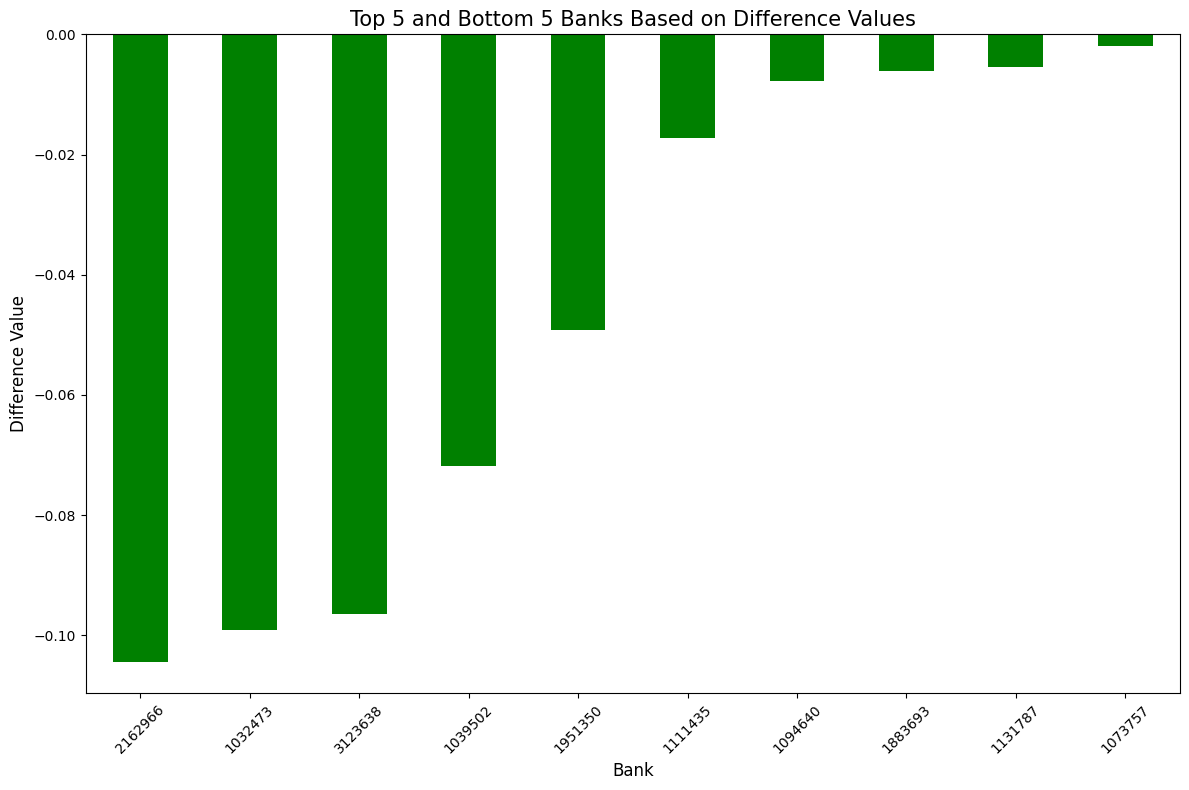

In [45]:
import matplotlib.pyplot as plt

# Combining top 5 and bottom 5 data
combined_data = pd.concat([top_5, bottom_5])

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
combined_data.plot(kind='bar', ax=ax, color=['green']*5 + ['red']*5)


# Setting title and labels
ax.set_title("Top 5 and Bottom 5 Banks Based on Difference Values", fontsize=15)
ax.set_ylabel("Difference Value", fontsize=12)
ax.set_xlabel("Bank", fontsize=12)
ax.legend().remove()
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

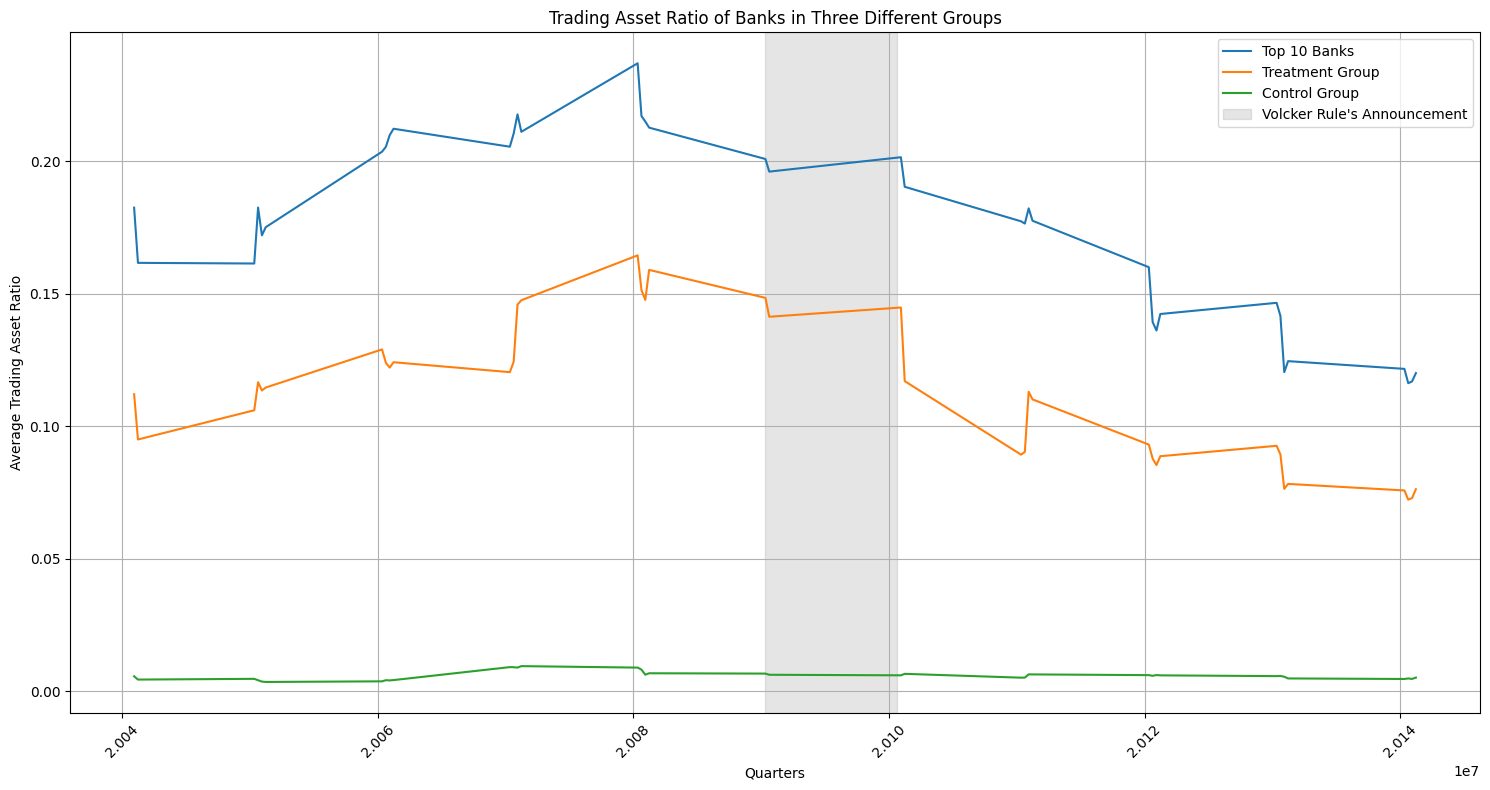

In [46]:
before_2007_data = data_bank[data_bank['rssd9999'] <= 20061231]

# Identify the 10 bank holding companies with the highest average trading asset ratio in the 15 quarters before 2007
top_10_banks = before_2007_data.groupby('rssd9001')['bhc_avgtradingratio'].mean().nlargest(10).index

# Filter data for these top 10 banks
top_10_data = data_bank[data_bank['rssd9001'].isin(top_10_banks)]
avg_top_10 = top_10_data.groupby('rssd9999')['bhc_avgtradingratio'].mean()

# Treatment group: Banks with average trading asset ratio greater than 3%
treatment_banks = before_2007_data.groupby('rssd9001')['bhc_avgtradingratio'].mean()
treatment_banks = treatment_banks[treatment_banks > 0.03].index
treatment_data = data_bank[data_bank['rssd9001'].isin(treatment_banks)]
avg_treatment = treatment_data.groupby('rssd9999')['bhc_avgtradingratio'].mean()

# Control group: For simplicity, and due to the lack of propensity scores, we'll consider banks with average trading asset ratio between 0 and 3%
control_banks = treatment_banks = before_2007_data.groupby('rssd9001')['bhc_avgtradingratio'].mean()
control_banks = control_banks[(control_banks > 0) & (control_banks <= 0.03)].index
control_data = data_bank[data_bank['rssd9001'].isin(control_banks)]
avg_control = control_data.groupby('rssd9999')['bhc_avgtradingratio'].mean()

# Plotting the data
plt.figure(figsize=(15, 8))

plt.plot(avg_top_10, label="Top 10 Banks")
plt.plot(avg_treatment, label="Treatment Group")
plt.plot(avg_control, label="Control Group")

# Shaded region for the Volcker Rule's announcement period from 2009 Q3 to 2010 Q2
plt.axvspan(20090331, 20100630, color='gray', alpha=0.2, label="Volcker Rule's Announcement")

plt.title("Trading Asset Ratio of Banks in Three Different Groups")
plt.xlabel("Quarters")
plt.ylabel("Average Trading Asset Ratio")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

### The blue line represents the average trading asset ratio of the 10 bank holding companies with the highest trading asset ratio in the 15 quarters before 2007. The orange line represents the average trading asset ratio of the treatment group (banks with an average trading asset ratio greater than 3%). The green line represents the average trading asset ratio of the control group (banks with a non-zero but less than 3% average trading asset ratio).The shaded gray region indicates the Volcker Rule's announcement period from 2009 Q3 to 2010 Q2.

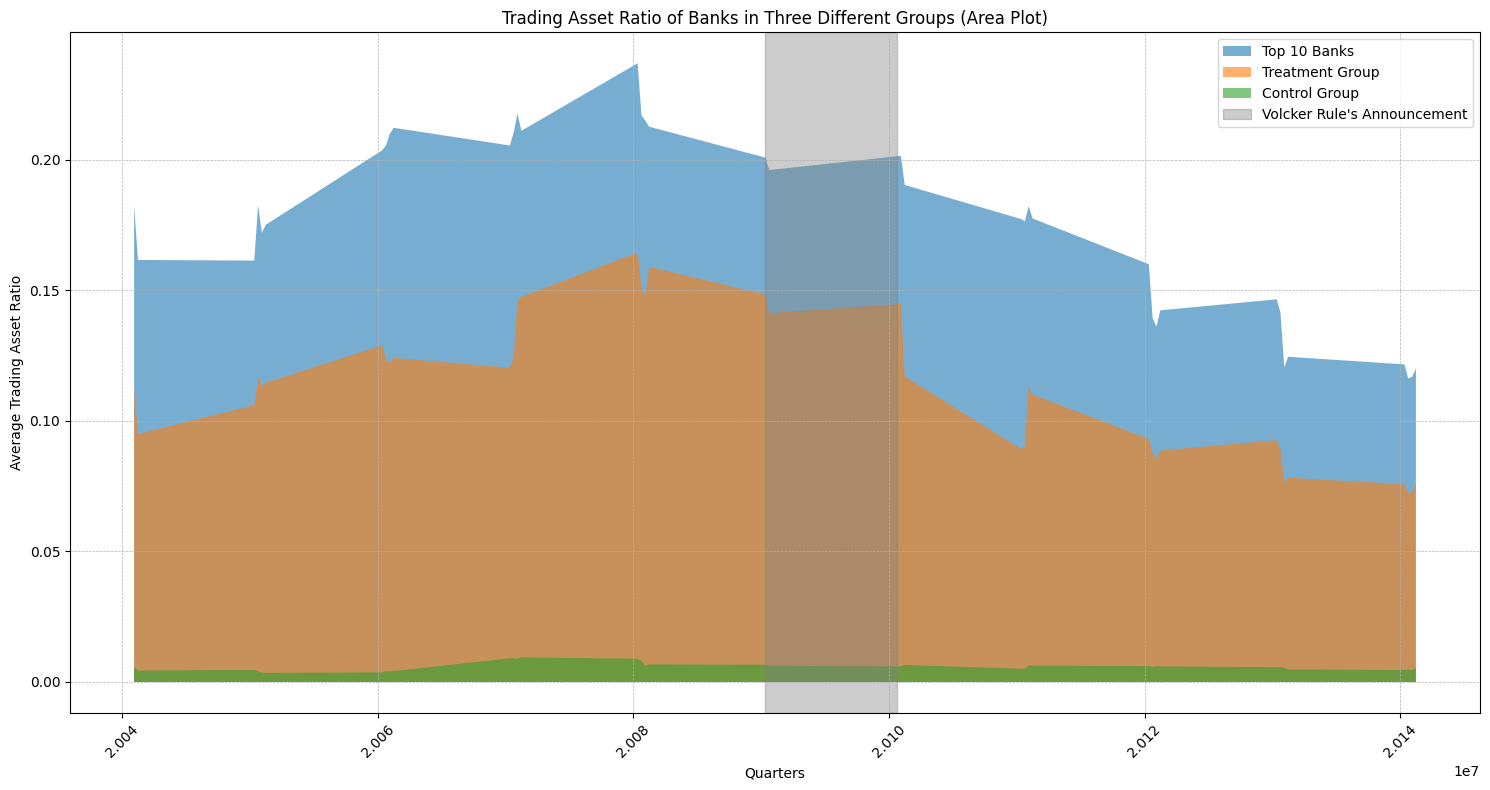

In [47]:
plt.figure(figsize=(15, 8))

# Plotting the data as an area plot
plt.fill_between(avg_top_10.index, avg_top_10, label="Top 10 Banks", alpha=0.6)
plt.fill_between(avg_treatment.index, avg_treatment, label="Treatment Group", alpha=0.6)
plt.fill_between(avg_control.index, avg_control, label="Control Group", alpha=0.6)

# Shaded region for the Volcker Rule's announcement period from 2009 Q3 to 2010 Q2
plt.axvspan(20090331, 20100630, color='gray', alpha=0.4, label="Volcker Rule's Announcement")

plt.title("Trading Asset Ratio of Banks in Three Different Groups (Area Plot)")
plt.xlabel("Quarters")
plt.ylabel("Average Trading Asset Ratio")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.show()

### The shaded areas represent the average trading asset ratio for the three groups: Top 10 banks, Treatment group, and Control group. The gray-shaded region indicates the Volcker Rule's announcement period from 2009 Q3 to 2010 Q2.Area plots are useful for visually emphasizing the magnitude and trend of values over time for different groups. The overlap in shaded regions allows for a comparison between the groups across different quarters.

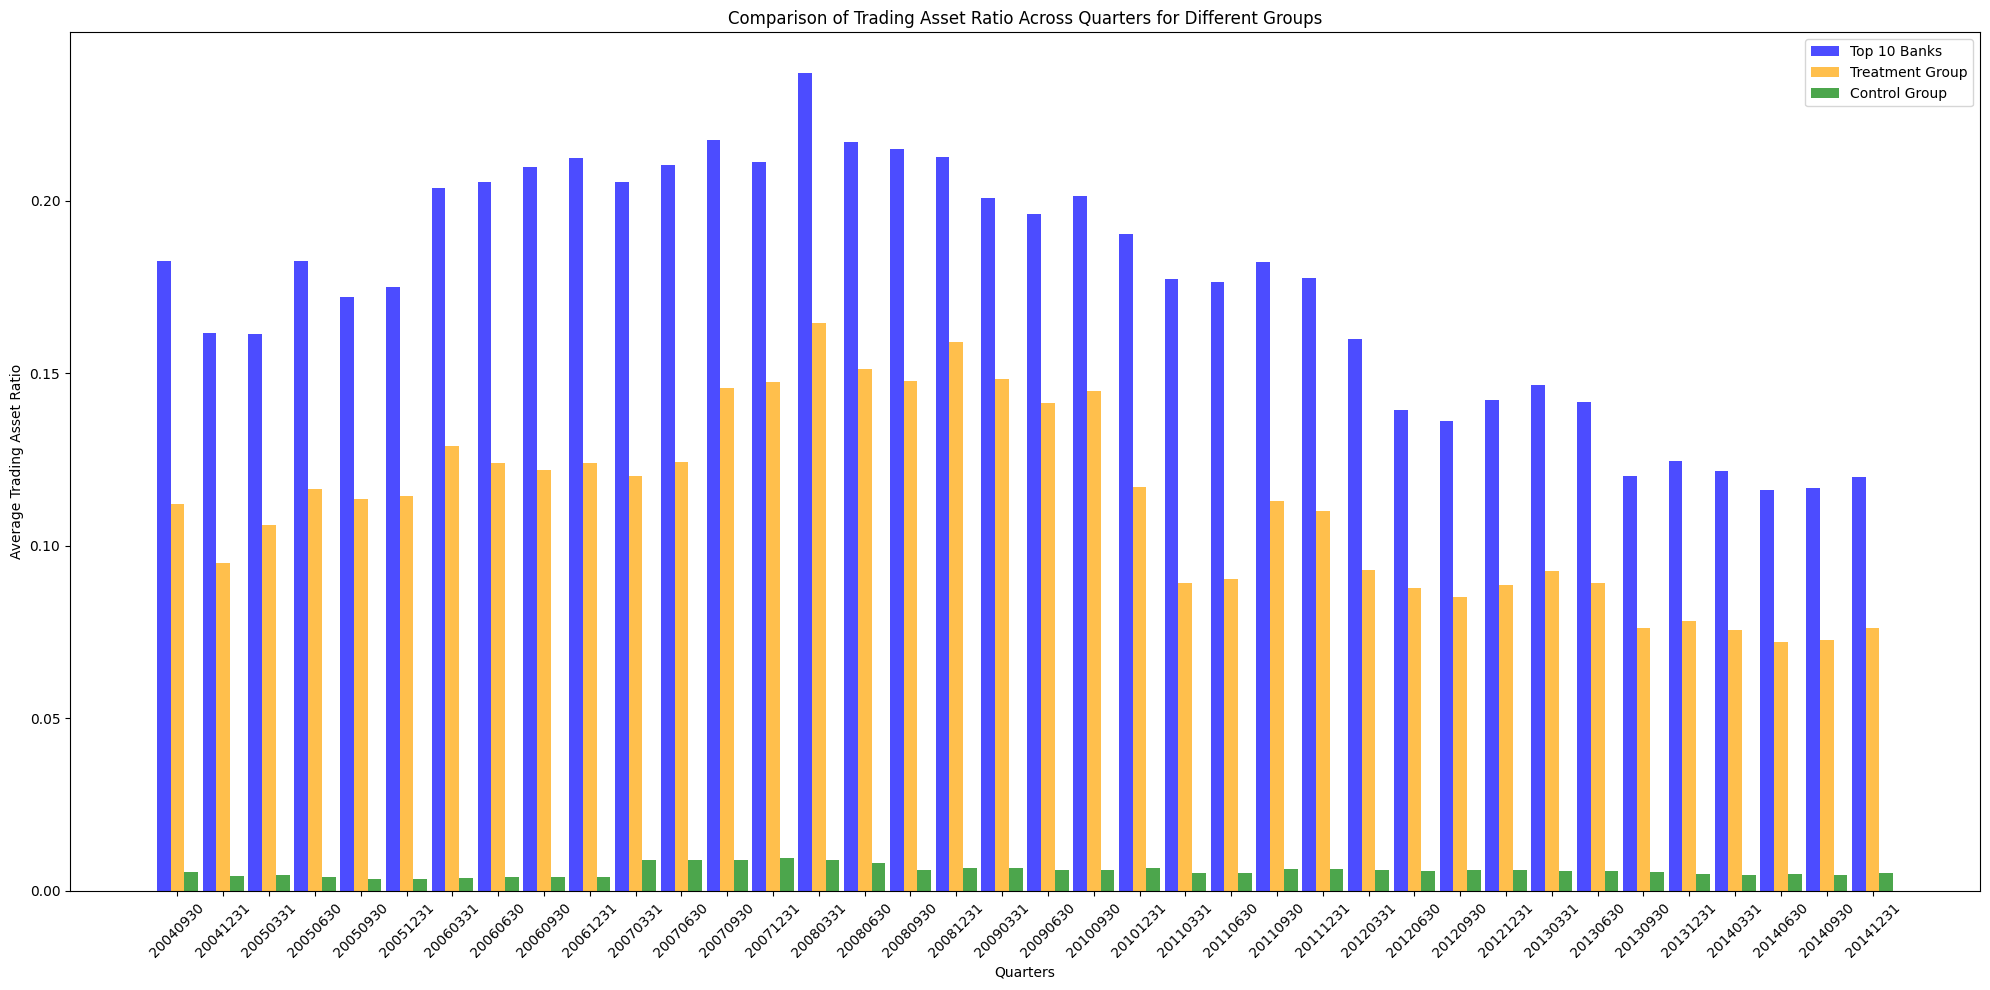

In [48]:
# Setting up the data for the bar graph
quarters = data_bank['rssd9999'].unique()
width = 0.3  # width of the bars
ind = range(len(quarters))  # the label locations

# Plotting the bar graph
plt.figure(figsize=(20, 10))

# Bars for the top 10 banks
plt.bar(ind, avg_top_10, width, label='Top 10 Banks', color='blue', alpha=0.7)

# Bars for the treatment group
plt.bar([i + width for i in ind], avg_treatment, width, label='Treatment Group', color='orange', alpha=0.7)

# Bars for the control group
plt.bar([i + width*2 for i in ind], avg_control, width, label='Control Group', color='green', alpha=0.7)

# Labeling, title, and legend
plt.xlabel('Quarters')
plt.ylabel('Average Trading Asset Ratio')
plt.title('Comparison of Trading Asset Ratio Across Quarters for Different Groups')
plt.xticks([i + width for i in ind], [str(int(q)) for q in quarters], rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

### Blue bars represent the Top 10 Banks.Orange bars represent the Treatment Group.Green bars represent the Control Group.

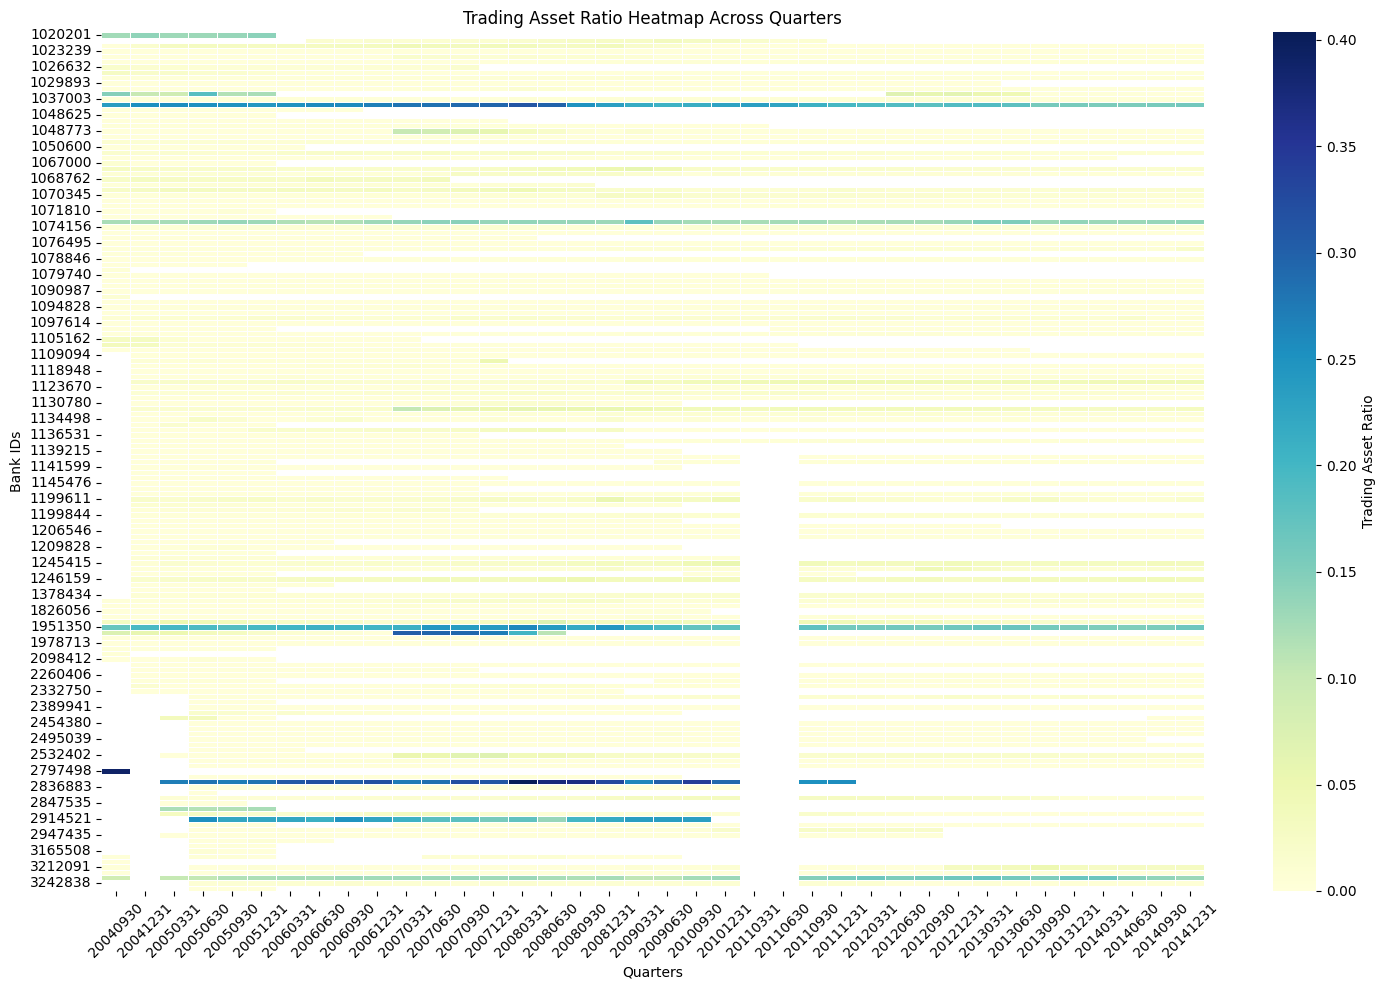

In [50]:
import seaborn as sns
# Correcting the bank IDs reference for the heatmap
banks_to_consider = list(top_10_banks) + list(treatment_banks) + list(control_banks)
heatmap_data = data_bank[data_bank['rssd9001'].isin(banks_to_consider)].pivot_table(index='rssd9001', columns='rssd9999', values='bhc_avgtradingratio')

plt.figure(figsize=(15, 10))
sns.heatmap(heatmap_data, cmap="YlGnBu", cbar_kws={'label': 'Trading Asset Ratio'}, linewidths=.5)

plt.title("Trading Asset Ratio Heatmap Across Quarters")
plt.xlabel("Quarters")
plt.ylabel("Bank IDs")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### The Y-axis represents the individual banks from the three groups.The X-axis represents the quarters.The color intensity reflects the trading asset ratio for each bank in each quarter, with darker shades indicating higher ratios.This visualization provides a quick way to see how the trading asset ratio of each bank evolves over time and to compare banks based on their trading asset ratio in specific quarters.

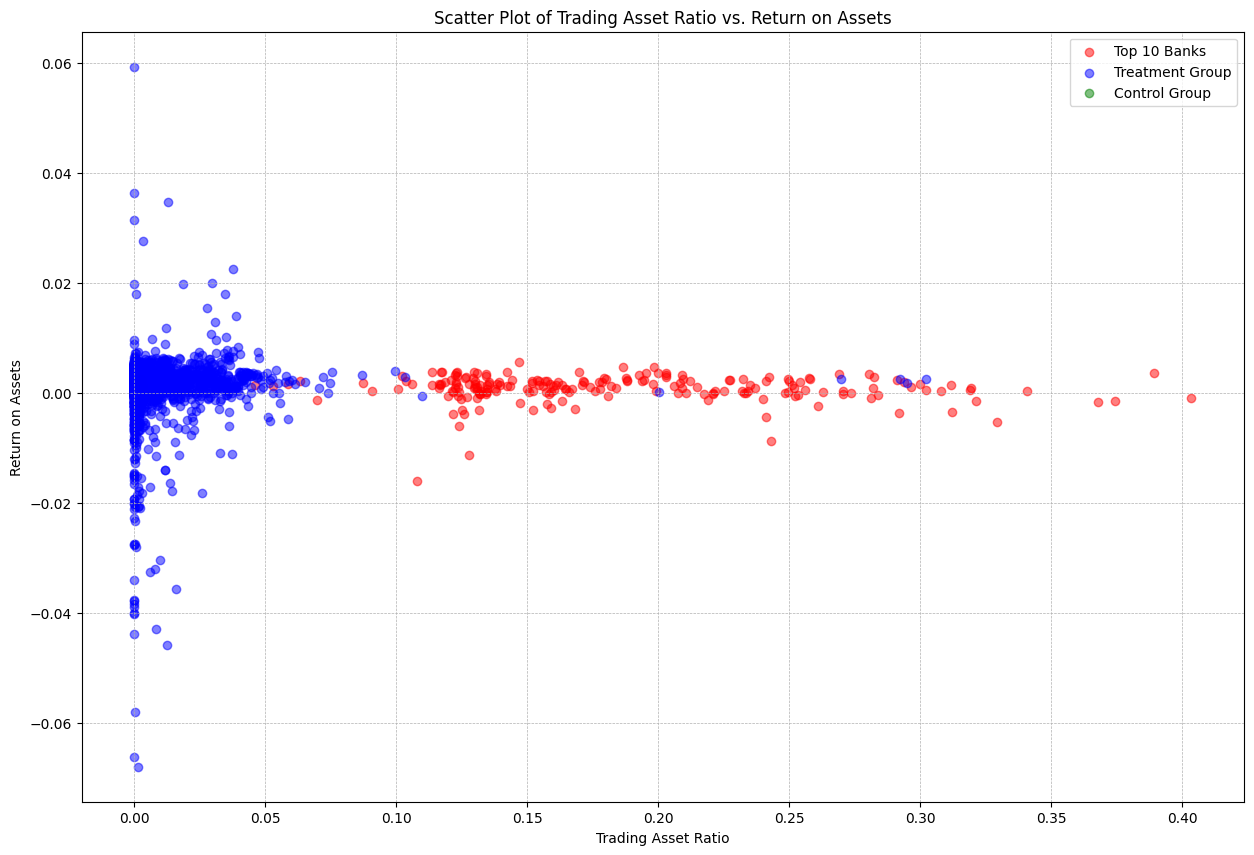

In [51]:
# Extract data for scatter plot
scatter_data = data_bank[data_bank['rssd9001'].isin(banks_to_consider)]

# Define colors for the groups
colors = scatter_data['rssd9001'].apply(lambda x: 'red' if x in top_10_banks else ('blue' if x in treatment_banks else 'green'))
labels = scatter_data['rssd9001'].apply(lambda x: 'Top 10 Banks' if x in top_10_banks else ('Treatment Group' if x in treatment_banks else 'Control Group'))

plt.figure(figsize=(15, 10))
for color, label in zip(['red', 'blue', 'green'], ['Top 10 Banks', 'Treatment Group', 'Control Group']):
    subset = scatter_data[colors == color]
    plt.scatter(subset['bhc_avgtradingratio'], subset['dep_roa1'], color=color, label=label, alpha=0.5)

plt.title('Scatter Plot of Trading Asset Ratio vs. Return on Assets')
plt.xlabel('Trading Asset Ratio')
plt.ylabel('Return on Assets')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

### The Top 10 Banks (in red) generally have higher trading asset ratios compared to the other groups. This is consistent with the definition of this group, which includes banks with the highest trading asset ratios in the 15 quarters before 2007.
### The Treatment Group (in blue) and Control Group (in green) banks seem to have a wider spread in trading asset ratios, with many banks clustered towards the lower end.
### Return on Assets:

### There isn't a strong visible pattern indicating that a higher trading asset ratio leads to a higher return on assets (or vice versa). This suggests that other factors might be influencing the return on assets.
### While some banks with higher trading asset ratios (especially among the Top 10 Banks) do have higher return on assets, there are also many banks with lower trading asset ratios that achieve similar returns.
## Overlap Between Groups:

### The three groups overlap in the scatter plot, especially in the region of lower trading asset ratios. This indicates that while the groups are distinguished by their trading practices, their performance (in terms of return on assets) can be quite similar.
### No Distinct Clustering:

### There isn't a distinct clustering of points for any group that would indicate a strong correlation between trading asset ratio and return on assets. Banks with similar trading asset ratios can have a wide range of return on assets values.